# Tutorial 2: Introduction to Flux

**Author:** Carlo Lucibello

TODO - add a description of the tutorial

Flux.jl relies on the following packages: Zygote.jl for automatic differentiation, NNlib.jl for neural network primitives, CUDA.jl for nvidia gpu support, MLUtils.jl for data loading and manipulation utilities, and Optmisers.jl for optimisation algorithms.

In [15]:
## Standard libraries
using Random, Statistics, LinearAlgebra, Pkg

## Imports for plotting
using Plots

## Progress bar
using ProgressMeter

## The Basics of Flux

We will start with reviewing the very basic concepts of Flux. As a prerequisite, we recommend to be familiar with manipulating julia `Array`s as most machine learning frameworks are based on very similar concepts. If you are not familiar with arrays yet, don't worry, we will show some basics in this notebook. Also, you can alsway refer to the official [manual](https://docs.julialang.org/en/v1/manual/arrays/).

So, let's start with importing Flux. As a first step, we can check its version:

In [16]:
using Flux
Pkg.status("Flux")

Status `~/Git/uvadlc_notebooks/Project.toml`
  [587475ba] Flux v0.13.15


At the time of writing this tutorial, the current stable version is 0.13.15. The compatibility bounds in the `Project.toml` defining your julia environment will make sure that you will use a version < 0.14, therefore containing non breaking changes in the interface. If you are not familiar with the concept of julia environments, you can refer to the [official documentation](https://julialang.github.io/Pkg.jl/v1/environments/).

Julia provides functions that are stochastic like generating random numbers. However, a very good practice is to setup your code to be reproducible with the exact same random numbers. This is why we set a seed below. 

In [17]:
Random.seed!(42) # Setting the seed

TaskLocalRNG()

If you are using a GPU device, you have to set the seed on the GPU as well 

In [18]:
using CUDA
CUDA.allowscalar(false)

CUDA.seed!(17)

UndefVarError: UndefVarError: `libcuda` not defined

### Arrays

Flux works with native `Array` types, and more generally with any type that implements the `AbstractArray` interface. This means that you can use any array type that you want, as long as it implements the required methods. For instance, you can use `CuArray` from the CUDA.jl package to work with GPU arrays.

This is unlike python machine learning frameworks, where you have to use the specific array type provided by the framework. For instance, in PyTorch you have to use `torch.array` to work with arrays.

In general, julia libraries are less monolithic than python libraries, and you can use different libraries together. This is one of the main reasons why julia is so flexible.


Multi-dimensional arrays, or arrays, are a generalization of concepts you already know. For instance, a vector is a 1-D tensor, and a matrix a 2-D tensor. When working with neural networks, we will use tensors of various shapes and number of dimensions.

#### Initialization

Let's first start by looking at different ways of creating an array. There are many possible options, the simplest one is to call `zeros` passing the desired shape as input argument:

In [19]:
zeros(2, 3, 4)

2×3×4 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 4] =
 0.0  0.0  0.0
 0.0  0.0  0.0

There are many alternatives including:

* `zeros`: Creates a array filled with zeros
* `ones`: Creates a array filled with ones
* `rand`: Creates a array with random values uniformly sampled between 0 and 1
* `randn`: Creates a array with random values sampled from a normal distribution with mean 0 and variance 1
* `range`: Creates a array containing linearly spaced values. Also done with the syntax `start:step:stop`.
* `collect` (input list): Creates a array from the list elements you provide

In [20]:
# Create a tensor with random values between 0 and 1 with the shape [2, 3, 4]
x = rand(2, 3, 4)

2×3×4 Array{Float64, 3}:
[:, :, 1] =
 0.173575  0.258585  0.527015
 0.321662  0.166439  0.483022

[:, :, 2] =
 0.390663  0.980758   0.544758
 0.802763  0.0944314  0.433914

[:, :, 3] =
 0.211228  0.347508  0.0269848
 0.183429  0.622647  0.978639

[:, :, 4] =
 0.989312   0.634981  0.65996
 0.0552982  0.837335  0.812019

You can obtain the shape of an array using the `size` method:

In [21]:
size(x)

(2, 3, 4)

#### Operations

The simplest operation is to add two arrays. You can use the dot `.` operator to apply the operation element-wise: 

In [22]:
x1 = rand(2, 3)
x2 = rand(2, 3)
y = x1 .+ x2

2×3 Matrix{Float64}:
 1.43521   0.557431  1.51766
 0.537807  0.542044  0.665821

Calling `x1 .+ x2` creates a new array containing the sum of the two inputs. However, we can also use in-place operations that are applied directly on the memory of an array. We therefore change the values of `x2` without the chance to re-accessing the values of `x2` before the operation. An example is shown below:

In [23]:
x1 = rand(2, 3)
x2 = rand(2, 3)
@show x1 x2;

x1 = [0.2961798562577662 0.3560771717464667 0.7573124834313315; 0.9996851103236141 0.7314774379355179 0.6191737590389158]
x2 = [0.27954197009573767 0.5484002542407093 0.34476325694907894; 0.3201287865461063 0.6198420745581052 0.11156876576082264]


In [24]:
x2 .+= x1
@show x1  x2;

x1 = [0.2961798562577662 0.3560771717464667 0.7573124834313315; 0.9996851103236141 0.7314774379355179 0.6191737590389158]
x2 = [0.5757218263535039 0.904477425987176 1.1020757403804105; 1.3198138968697204 1.3513195124936233 0.7307425247997384]


Another common operation aims at changing the shape of an array. Am array of size (2,3) can be re-organized to any other shape with the same number of elements (e.g. an arrat of size (6), or (3,2), ...). This operation is done using `reshape`:

In [25]:
x = [1:6;]

6-element Vector{Int64}:
 1
 2
 3
 4
 5
 6

In [26]:
x = reshape(x, 2, 3)

2×3 Matrix{Int64}:
 1  3  5
 2  4  6

In [27]:
x = permutedims(x, (2, 1)) # Swapping dimension 1 and 2

3×2 Matrix{Int64}:
 1  2
 3  4
 5  6

Other commonly used operations include matrix multiplications, which are essential for neural networks. Quite often, we have an input vector $\mathbf{x}$, which is transformed using a learned weight matrix $\mathbf{W}$. There are multiple ways and functions to perform matrix multiplication, some of which we list below:


* `*`: Performs matrix by vector or matrix by matrix product but doesn't support broadcasting.
* `NNlib.batched_mul`: Performs the matrix product with a support batch dimension.
* `Tullio.@tullio`: Performs matrix multiplications and more (i.e. sums of products) using the Einstein summation convention. Explanation of the Einstein sum can be found in assignment 1.


In [28]:
x = reshape([1:6;], 3, 2)

3×2 Matrix{Int64}:
 1  4
 2  5
 3  6

In [29]:
W = reshape([1:12;], 4, 3)

4×3 Matrix{Int64}:
 1  5   9
 2  6  10
 3  7  11
 4  8  12

In [30]:
W * x

4×2 Matrix{Int64}:
 38   83
 44   98
 50  113
 56  128

#### Indexing

We often have the situation where we need to select a part of a tensor. Indexing works just like in numpy, so let's try it:

In [31]:
x = reshape([1:12;], 4, 3)

4×3 Matrix{Int64}:
 1  5   9
 2  6  10
 3  7  11
 4  8  12

In [32]:
x[:, 2]   # Second column

4-element Vector{Int64}:
 5
 6
 7
 8

In [33]:
x[:,1]      # First row

4-element Vector{Int64}:
 1
 2
 3
 4

In [34]:
x[1:2, end-1] # First two rows, last column

2-element Vector{Int64}:
 5
 6

In [35]:
x[2:3, :] # Middle two rows

2×3 Matrix{Int64}:
 2  6  10
 3  7  11

### Dynamic Computation Graph and Backpropagation

One of the main reasons for using Flux in Deep Learning projects is that we can automatically get **gradients** of functions that we define. We will mainly use Flux for implementing neural networks, and they are just fancy functions. If we use weight matrices in our function that we want to learn, then those are called the **parameters** or simply the **weights**.

Given an input $\mathbf{x}$, we define our function by **manipulating** that input, usually by matrix-multiplications with weight matrices and additions with so-called bias vectors. As we manipulate our input, we are implicitely creating a **computational graph**. This graph shows how to arrive at our output from our input. 
Flux, and, more specifically, it's automatic differentiation engine Zygote, will use julia's ability to introspect the code to **trace** the graph. This means that we don't have to explicitly define the graph, we just have to define the function that we want to compute.

So, to recap: the only thing we have to do is to compute the **output**, and then we can ask Flux/Zygote to automatically get the **gradients**. 

> **Note:  Why do we want gradients?** Consider that we have defined a function, a neural net, that is supposed to compute a certain output $y$ for an input vector $\mathbf{x}$. We then define an **error measure** that tells us how wrong our network is; how bad it is in predicting output $y$ from input $\mathbf{x}$. Based on this error measure, we can use the gradients to **update** the weights $\mathbf{W}$ that were responsible for the output, so that the next time we present input $\mathbf{x}$ to our network, the output will be closer to what we want.


In order to get familiar with the concept of a computation graph, we will create one for the following function:

$$y = \frac{1}{n}\sum_{i=1}^n \left[(x_i + 2)^2 + 3\right]$$

You could imagine that $x$ are our parameters,$n$ thery number, and we want to optimize (either maximize or minimize) the output $y$. For this, we want to obtain the gradients $\partial y / \partial \mathbf{x}$. For our example, we'll use $\mathbf{x}=[0,1,2]$ as our input.

In [36]:
x = Float32[0, 1, 2]

3-element Vector{Float32}:
 0.0
 1.0
 2.0

Now let's define our loss function. You can combine multiple operations in a single line, but we will separate them here to get a better understanding of how each operation is added to the computation graph.

In [37]:
function loss(x)
    a = x .+ 2
    b = a.^2
    c = b .+ 3
    y = mean(c)
    return y
end

loss(x)

12.666667f0

Using the statements above, we have created a computation graph that looks similar to the figure below:

<center style="width: 100%"><img src="pytorch_computation_graph.svg" width="200px"></center>

We calculate $a$ based on the inputs $x$ and the constant $2$, $b$ is $a$ squared, and so on. The visualization is an abstraction of the dependencies between inputs and outputs of the operations we have applied. We can perform backpropagation on the computation graph by calling the function `gradient()`:

In [38]:
g = gradient(loss, x)

(Float32[1.3333334, 2.0, 2.6666667],)

`g[1]` will now contain the gradient $\partial y/ \partial \mathcal{x}$, and this gradient indicates how a change in $\mathbf{x}$ will affect output $y$ given the current input $\mathbf{x}=[0,1,2]$:

We can also verify these gradients by hand. We will calculate the gradients using the chain rule, in the same way as Zygote did it:

$$\frac{\partial y}{\partial x_i} = \frac{\partial y}{\partial c_i}\frac{\partial c_i}{\partial b_i}\frac{\partial b_i}{\partial a_i}\frac{\partial a_i}{\partial x_i}$$

Note that we have simplified this equation to index notation, and by using the fact that all operation besides the mean do not combine the elements in the tensor. The partial derivatives are:

$$
\frac{\partial a_i}{\partial x_i} = 1,\hspace{1cm}
\frac{\partial b_i}{\partial a_i} = 2\cdot a_i\hspace{1cm}
\frac{\partial c_i}{\partial b_i} = 1\hspace{1cm}
\frac{\partial y}{\partial c_i} = \frac{1}{3}
$$

Hence, with the input being $\mathbf{x}=[0,1,2]$, our gradients are $\partial y/\partial \mathbf{x}=[4/3,2,8/3]$. The previous code cell should have printed the same result.

### GPU support

A crucial feature of F;ux is the support of GPUs, short for Graphics Processing Unit. A GPU can perform many thousands of small operations in parallel, making it very well suitable for performing large matrix operations in neural networks. When comparing GPUs to CPUs, we can list the following main differences (credit: [Kevin Krewell, 2009](https://blogs.nvidia.com/blog/2009/12/16/whats-the-difference-between-a-cpu-and-a-gpu/)) 

<center style="width: 100%"><img src="comparison_CPU_GPU.png" width="700px"></center>

CPUs and GPUs have both different advantages and disadvantages, which is why many computers contain both components and use them for different tasks. In case you are not familiar with GPUs, you can read up more details in this [NVIDIA blog post](https://blogs.nvidia.com/blog/2009/12/16/whats-the-difference-between-a-cpu-and-a-gpu/) or [here](https://www.intel.com/content/www/us/en/products/docs/processors/what-is-a-gpu.html). 

GPUs can accelerate the training of your network up to a factor of $100$ which is essential for large neural networks. PyTorch implements a lot of functionality for supporting GPUs (mostly those of NVIDIA due to the libraries [CUDA](https://developer.nvidia.com/cuda-zone) and [cuDNN](https://developer.nvidia.com/cudnn)). First, let's check whether you have a GPU available:

In [39]:
using CUDA # Import the CUDA package
CUDA.allowscalar(false) # Disallow scalar operations on the GPU

gpu_avail = CUDA.functional()
print("Is the GPU available? $(gpu_avail)")

Is the GPU available? false

By default, all arrays you create are stored on the CPU. We can push a tensor to the GPU by using the function `CUDA.cu`, or `Flux.gpu`. However, it is often a good practice to define a `device` object in your code which points to the GPU if you have one, and otherwise to the CPU. Then, you can write your code with respect to this device object, and it allows you to run the same code on both a CPU-only system, and one with a GPU. Let's try it below. We can specify the device as follows: 

In [40]:
device = CUDA.functional() ? Flux.gpu : Flux.cpu

cpu (generic function with 1 method)

Now let's create a tensor and push it to the device:

In [41]:
x = zeros(2, 3) |> device

2×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0

In case you have a GPU, you should now see that `x` is a `CuArray{Float32}`. We can also compare the runtime of a large matrix multiplication on the CPU with a operation on the GPU:

In [42]:
using BenchmarkTools

x = randn(5000, 5000)

## CPU version
@btime $x * $x;

## GPU version
if CUDA.functional()
    x = x |> Flux.gpu
    @btime CUDA.@sync $x * $x;
end

  1.045 s (2 allocations: 190.73 MiB)


Depending on the size of the operation and the CPU/GPU in your system, the speedup of this operation can be >50x. As `*` operations are very common in neural networks, we can already see the great benefit of training a NN on a GPU. The time estimate can be relatively noisy here because we haven't run it for multiple times. Feel free to extend this, but it also takes longer to run.

When generating random numbers, the seed between CPU and GPU is not synchronized. Hence, we need to set the seed on the GPU separately to ensure a reproducible code. Note that due to different GPU architectures, running the same code on different GPUs does not guarantee the same random numbers. Still, we don't want that our code gives us a different output every time we run it on the exact same hardware. Hence, we also set the seed on the GPU:

In [43]:
# GPU operations have a separate seed we also want to set
if CUDA.functional()
    CUDA.seed!(42)
end

## Learning by example: Continuous XOR

If we want to build a neural network in julia, we could specify all our parameters (weight matrices, bias vectors) using arrays, ask Zygote to calculate the gradients and then adjust the parameters. But things can quickly get cumbersome if we have a lot of parameters. Flux makes building neural networks more convenient. 

We will introduce the libraries and all additional parts you might need to train a neural network in Flux, using a simple example classifier on a simple yet well known example: XOR. Given two binary inputs $x_1$ and $x_2$, the label to predict is $1$ if either $x_1$ or $x_2$ is $1$ while the other is $0$, or the label is $0$ in all other cases. The example became famous by the fact that a single neuron, i.e. a linear classifier, cannot learn this simple function.
Hence, we will learn how to build a small neural network that can learn this function. 
To make it a little bit more interesting, we move the XOR into continuous space and introduce some gaussian noise on the binary inputs. Our desired separation of an XOR dataset could look as follows:

<center style="width: 100%"><img src="continuous_xor.svg" width="350px"></center>

### The model

Flux defines a series of useful network layers. A full list can be found [here](http://fluxml.ai/Flux.jl/stable/models/layers/). In case you need a certain network layer, check the documentation of the package first before writing the layer yourself as the package likely contains the code for it already. We import it below:

Additionally, there is also `NNlib.jl`. It contains functions that are used in network layers. This is in contrast to `Flux` which defines them as types that uses a lot of functionalities from NNlib. Hence, the functional package is useful in many situations, and although Flux re-exports all of NNlib's exported methods,  we can explicitly import the library:

In [44]:
using NNlib

#### A Flux model

A Flux model is just a plain julia type, with the only addition of `@functor` functionality. The basic template of a model is as follows:

In [45]:
struct MyModel
    # ... fields
end

Flux.@functor MyModel # mark every numerical array as a parameter

function MyModel() # Constructor
    # ... initialization
end

function (m::MyModel)(x) # Forward pass
    # ... forward pass
end

In [46]:
println(@doc Flux.@functor)

```
@functor T
@functor T (x,)
```

Adds methods to [`functor`](@ref) allowing recursion into objects of type `T`, and reconstruction. Assumes that `T` has a constructor accepting all of its fields, which is true unless you have provided an inner constructor which does not.

By default all fields of `T` are considered [`children`](@ref);  this can be restricted be restructed by providing a tuple of field names.

# Examples

```jldoctest
julia> struct Foo; x; y; end

julia> @functor Foo

julia> Functors.children(Foo(1,2))
(x = 1, y = 2)

julia> _, re = Functors.functor(Foo(1,2));

julia> re((10, 20))
Foo(10, 20)

julia> struct TwoThirds a; b; c; end

julia> @functor TwoThirds (a, c)

julia> ch2, re3 = Functors.functor(TwoThirds(10,20,30));

julia> ch2
(a = 10, c = 30)

julia> re3(("ten", "thirty"))
TwoThirds("ten", 20, "thirty")

julia> fmap(x -> 10x, TwoThirds(Foo(1,2), Foo(3,4), 56))
TwoThirds(Foo(10, 20), Foo(3, 4), 560)
```



The forward function is where the computation of the model is taken place, and is executed when you call the model (`nn = MyModel(); nn(x)`). In the constructor function, we usually create the parameters of the model, or defining other models that are used in the forward function. The backward calculation is done automatically, but could be overwritten as well if wanted.

#### Simple classifier
We can now make use of the pre-defined layers in Flux, and define our own small neural network. We will use a minimal network with a input layer, one hidden layer with tanh as activation function, and a output layer. In other words, our networks should look something like this:

<center width="100%"><img src="small_neural_network.svg" width="300px"></center>

The input neurons are shown in blue, which represent the coordinates $x_1$ and $x_2$ of a data point. The hidden neurons including a tanh activation are shown in white, and the output neuron in red.
We can define this as follows:

In [116]:
struct SimpleClassifier{C}
    chain::C
end

Flux.@functor SimpleClassifier

function SimpleClassifier(; num_inputs, num_hidden, num_outputs)
    chain = Chain(Dense(num_inputs => num_hidden, tanh),
                  Dense(num_hidden => num_outputs))
    return SimpleClassifier(chain)
end

(model::SimpleClassifier)(x) = model.chain(x)

Base.show(io::IO, model::SimpleClassifier) = print(io, "SimpleClassifier($(model.chain))")

For the examples in this notebook, we will use a tiny neural network with two input neurons and four hidden neurons. As we perform binary classification, we will use a single output neuron. Note that we do not apply a sigmoid on the output yet. This is because other functions, especially the loss, are more efficient and precise to calculate on the original outputs instead of the sigmoid output. We will discuss the detailed reason later.

In [48]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

SimpleClassifier(Chain(Dense(2 => 4, tanh), Dense(4 => 1)))

Printing a `Chain` object will show you the layers of the network:

In [49]:
model.chain

Chain(
  Dense(2 => 4, tanh),                  # 12 parameters
  Dense(4 => 1),                        # 5 parameters
)                   # Total: 4 arrays, 17 parameters, 324 bytes.

Each linear layer has a weight matrix of the shape `[output, input]`, and a bias of the shape `[output]`.

In [50]:
model.chain[1].weight

4×2 Matrix{Float32}:
  0.95625   -0.515876
  0.340059  -0.38061
 -0.328979   0.711864
  0.693201  -0.835912

In [51]:
model.chain[1].bias

4-element Vector{Float32}:
 0.0
 0.0
 0.0
 0.0

### The data

Flux also provides the `DataLoader` type to load the training and test data efficiently.

In [52]:
using Flux: DataLoader

The `DataLoader` is not defined in Flux itself, but re-exported from the MLUtils.jl package. The `DataLoader` wraps a dataset and iterates over batches of data. 

#### Custom dataset

The `DataLoader` supports any dataset type for which `MLUtils.numobs` and `MLUtils.getobs` are defined. By default, this two methods fall back to `length` and `getindex` respectively. Therefore, we just have to specify these two function in our custom dataset.

In [72]:
struct XORDataset
    n::Int
    data::Matrix{Float32}
    label::Vector{Int}
end

function XORDataset(n, std=0.1)
    data = rand(0:1, (2, n))
    label = Int.(sum(data, dims=1) .== 1) |> vec
    data += Float32(std) .* randn(Float32, size(data))
    return XORDataset(n, data, label)
end

Base.length(dataset::XORDataset) = dataset.n

function Base.getindex(dataset::XORDataset, idx)
    return dataset.data[:, idx], dataset.label[idx]
end

Let's try to create such a dataset and inspect it:

In [73]:
dataset = XORDataset(200)
println("Size of dataset:", length(dataset))
println("Data point 1: $(dataset[1])")

Size of dataset:200
Data point 1: (Float32[0.12878266, 0.99239737], 1)


To better relate to the dataset, we visualize the samples below. 

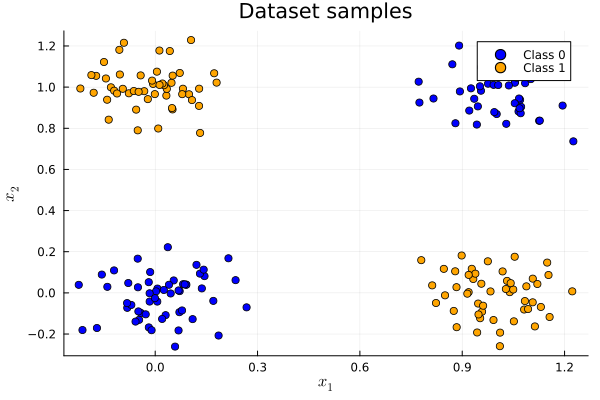

In [95]:
using Plots, LaTeXStrings

function visualize_samples(data, label)
    data = data |> cpu
    data_0 = data[:, label .== 0]
    data_1 = data[:, label .== 1]
    
    p = Plots.scatter(data_0[1,:], data_0[2,:], color=:blue, label="Class 0")
    p = Plots.scatter!(data_1[1,:], data_1[2,:], color=:orange, label="Class 1")
        
    Plots.title!("Dataset samples")
    Plots.ylabel!(L"x_2")
    Plots.xlabel!(L"x_1")
    return p
end

visualize_samples(dataset.data, dataset.label)


#### The data loader class


In [96]:
using Term # docstring are not shown in the notebook with ?DataLoader
tprint(@doc DataLoader)

    ┌──────────────────────────────────────────────────────────────────┐
    │  DataLoader(data; [batchsize, buffer, collate, parallel,         │
    │  partial, rng, shuffle])                                         │
    └──────────────────────────────────────────────────────────────────┘

An object that iterates over mini-batches of `data`, each mini-batch containing
`batchsize` observations (except possibly the last one).

Takes as input a single data array, a tuple (or a named tuple) of arrays, or
in general any `data` object that implements the `numobs` (@ref) and `getobs`
(@ref) methods.

The last dimension in each array is the observation dimension, i.e. the one
divided into mini-batches.

The original data is preserved in the `data` field of the DataLoader.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                              Arguments                               ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

  

Let's create a simple data loader below:

In [99]:
data_loader = DataLoader(dataset, batchsize=8, shuffle=true)

25-element DataLoader(::XORDataset, shuffle=true, batchsize=8)
  with first element:
  (2×8 Matrix{Float32}, 8-element Vector{Int64},)

In [104]:
# `first` catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = first(data_loader)

# The shape of the outputs are [d_1,...,d_N, batch_size] where d_1,...,d_N are the 
# dimensions of the data point returned from the dataset class
println("Data inputs ", size(data_inputs), "\n", data_inputs)
println("Data labels ", size(data_labels), "\n", data_labels)

Data inputs (2, 8)
Float32[-0.10505451 1.071293 0.12851653 -0.02161593 -0.055801447 -0.04260068 0.1367 -0.057596773; 1.1811881 0.8729882 0.9086212 0.94165087 0.8905476 1.0569068 0.021710787 -0.13955273]
Data labels (8,)
[1, 0, 1, 1, 1, 1, 0, 0]


### Optimization

After defining the model and the dataset, it is time to prepare the optimization of the model. During training, we will perform the following steps:

1. Get a batch from the data loader
2. Obtain the predictions from the model for the batch
3. Calculate the loss based on the difference between predictions and labels
4. Backpropagation: calculate the gradients for every parameter with respect to the loss
5. Update the parameters of the model in the direction of the gradients

We have seen how we can do step 1, 2 and 4 in Flux. Now, we will look at step 3 and 5.

#### Loss modules

We can calculate the loss for a batch by simply performing a few tensor operations as those are automatically added to the computation graph. For instance, for binary classification, we can use Binary Cross Entropy (BCE) which is defined as follows:

$$\mathcal{L}_{BCE} = -\sum_i \left[ y_i \log x_i + (1 - y_i) \log (1 - x_i) \right]$$

where $y$ are our labels, and $x$ our predictions, both in the range of $[0,1]$. However, Flux already provides a list of predefined loss functions which we can use (see [here](https://fluxml.ai/Flux.jl/stable/models/losses/) for a full list). For instance, for BCE, Flux has two functions: `binarycrossentropy` and `logitbinarycrossentropy`. While `binarycrossentropy` expects the inputs $x$ to be in the range $[0,1]$, i.e. the output of a sigmoid, `logitbinarycrossentropy` combines a sigmoid layer and the BCE loss in a single class. This version is numerically more stable than using a plain Sigmoid followed by a BCE loss because of the logarithms applied in the loss function. Hence, it is adviced to use loss functions applied on "logits" where possible (remember to not apply a sigmoid on the output of the model in this case!). For our model defined above, we therefore use the function `logitbinarycrossentropy`. 

#### Stochastic Gradient Descent

For updating the parameters, PyTorch provides the package `torch.optim` that has most popular optimizers implemented. We will discuss the specific optimizers and their differences later in the course, but will for now use the simplest of them: `torch.optim.SGD`. Stochastic Gradient Descent updates parameters by multiplying the gradients with a small constant, called learning rate, and subtracting those from the parameters (hence minimizing the loss). Therefore, we slowly move towards the direction of minimizing the loss. A good default value of the learning rate for a small network as ours is 0.1. 

In [107]:

# Input to the optimizer are the parameters of the model: model.parameters()
opt_state = Flux.setup(Descent(0.1), model)

(chain = (layers = ((weight = Leaf(Descent{Float64}(0.1), nothing), bias = Leaf(Descent{Float64}(0.1), nothing), σ = ()), (weight = Leaf(Descent{Float64}(0.1), nothing), bias = Leaf(Descent{Float64}(0.1), nothing), σ = ())),),)

Optimisers.jl provides the functions: `Optimisers.update!(opt_state, model, grad)` to update the parameters of the model.

### Training

Finally, we are ready to train our model. As a first step, we create a slightly larger dataset and specify a data loader with a larger batch size. 

In [109]:
train_dataset = XORDataset(2500)
train_dataloader = DataLoader(train_dataset, batchsize=128, shuffle=true)

20-element DataLoader(::XORDataset, shuffle=true, batchsize=128)
  with first element:
  (2×128 Matrix{Float32}, 128-element Vector{Int64},)

Now, we can write a small training function. Remember our five steps: load a batch, obtain the predictions, calculate the loss, backpropagate, and update. Additionally, we have to push all data and model parameters to the device of our choice (GPU if available). For the tiny neural network we have, communicating the data to the GPU actually takes much more time than we could save from running the operation on GPU. For large networks, the communication time is significantly smaller than the actual runtime making a GPU crucial in these cases. Still, to practice, we will push the data to GPU here. 

In [110]:
# Push model to device. Has to be only done once
model = model |> device

SimpleClassifier(Chain(Dense(2 => 4, tanh), Dense(4 => 1)))

In addition, we set our model to training mode. This is done by calling `model.train()`. There exist certain modules that need to perform a different forward step during training than during testing (e.g. BatchNorm and Dropout), and we can switch between them using `model.train()` and `model.eval()`.

In [125]:
function train_model!(model, optimizer, data_loader; num_epochs=100)
    # Set model to train mode
    
    # Training loop
    for epoch in 1:num_epochs
        for batch in data_loader
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            x, y = batch |> device

            grads = gradient(model) do model
                        ## Step 2: Run the model on the input data
                        preds = model(x)
                        preds = preds |> vec # Output is [1, batchsize], but we want [batchsize]
                        ## Step 3: Calculate the loss
                        loss = Flux.logitbinarycrossentropy(preds, y)
                        return loss
                    end ## Step 4: Perform backpropagation
            
            ## Step 5: Update the parameters
            Flux.update!(opt_state, model, grads[1])
        end
    end
end

train_model!(model, optimizer, train_data_loader)

#### Saving a model

After finish training a model, we save the model to disk so that we can load the same weights at a later time. For this, we can use the BSON package.

In [134]:
using BSON
BSON.@save "our_model.bson" model=Flux.cpu(model)

To load a model, we use the function `BSON.load` and pass the path to the file.

In [141]:
BSON.@load "our_model.bson" model

### Evaluation

Once we have trained a model, it is time to evaluate it on a held-out test set. As our dataset consist of randomly generated data points, we need to first create a test set with a corresponding data loader.

In [142]:
test_dataset = XORDataset(500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = DataLoader(test_dataset, batchsize=128, shuffle=false, partial=true) 

4-element DataLoader(::XORDataset, batchsize=128)
  with first element:
  (2×128 Matrix{Float32}, 128-element Vector{Int64},)

As metric, we will use accuracy which is calculated as follows:

$$acc = \frac{\#\text{correct predictions}}{\#\text{all predictions}} = \frac{TP+TN}{TP+TN+FP+FN}$$

where TP are the true positives, TN true negatives, FP false positives, and FN the fale negatives. 

In [148]:
function eval_model(model, data_loader)
    true_preds, num_preds = 0., 0.

    for batch in data_loader
        x, y = batch |> device
        
        ŷ = model(x)
        ŷ = sigmoid.(ŷ) # Sigmoid to map predictions between 0 and 1
        pred_labels = (ŷ .>= 0.5) |> vec # Binarize predictions to 0 and 1
        
        # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
        true_preds += sum(pred_labels .== y)
        num_preds += length(y)
    end
        
    acc = true_preds / num_preds
    println("Accuracy of the model: $(round(100.0*acc, sigdigits=3))")
end

eval_model (generic function with 1 method)

In [149]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.0


If we trained our model correctly, we should see a score close to 100% accuracy. However, this is only possible because of our simple task, and unfortunately, we usually don't get such high scores on test sets of more complex tasks.

#### Visualizing classification boundaries

To visualize what our model has learned, we can perform a prediction for every data point in a range of $[-0.5, 1.5]$, and visualize the predicted class as in the sample figure at the beginning of this section. This shows where the model has created decision boundaries, and which points would be classified as $0$, and which as $1$. We therefore get a background image out of blue (class 0) and orange (class 1). The spots where the model is uncertain we will see a blurry overlap. The specific code is less relevant compared to the output figure which should hopefully show us a clear separation of classes:

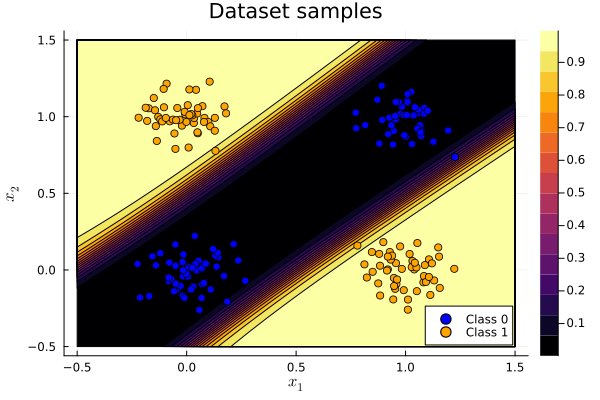

In [183]:
using MLUtils

function meshgrid(x1, x2)
    X1 = [x1 for _ in x2, x1 in x1]
    X2 = [x2 for x2 in x2, _ in x1]
    X1, X2
 end

function visualize_classification(model, data, label)
    data, label = data |> cpu, label |> cpu
    data_0 = data[:, label .== 0]
    data_1 = data[:, label .== 1]
    
    p = Plots.scatter(data_0[1,:], data_0[2,:], color=:blue, label="Class 0")
    p = Plots.scatter!(data_1[1,:], data_1[2,:], color=:orange, label="Class 1")
        
    
    x1 = range(-0.5, 1.5, step=0.01)
    x2 = range(-0.5, 1.5, step=0.01)
    xx1, xx2 = meshgrid(x1, x2)
    model_inputs = MLUtils.stack([xx1, xx2], dims=1)
    
    preds = model(model_inputs)
    preds = sigmoid.(preds)
    preds = dropdims(preds; dims=1)
    Plots.contour(x1, x2, preds, fill=true)

    p = Plots.scatter!(data_0[1,:], data_0[2,:], color=:blue, label="Class 0")
    p = Plots.scatter!(data_1[1,:], data_1[2,:], color=:orange, label="Class 1")
    
    Plots.title!("Dataset samples")
    Plots.ylabel!(L"x_2")
    Plots.xlabel!(L"x_1")
end

res = visualize_classification(model, dataset.data, dataset.label)


The decision boundaries might not look exactly as in the figure in the preamble of this section which can be caused by running it on CPU or a different GPU architecture. Nevertheless, the result on the accuracy metric should be the approximately the same. 